In [1]:
import pandas as pd
import numpy as np
import sys
import os

# Allows to get the module in utils
sys.path.append(os.path.abspath(".."))


from utils.load import load_data
from utils.preprocessing import preprocess
from utils.split import split_data

from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
# from sklearn.compose import ColumnTransformer

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

(4507, 20) (1409, 20) (1127, 20) (1409, 20) (1127,) (1409,)


2025-05-21 10:56:11.785079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 10:56:11.787660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 10:56:11.795637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747817771.810407  113614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747817771.814716  113614 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747817771.824783  113614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Load data
df = load_data()

In [3]:
# Split and preprocess datas set
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

X_train_processed, X_test_processed, X_val_processed, y_test_encoding, y_train_encoded, y_val_encoding, pipeline, le = preprocess(X_train, X_val, X_test, y_train, y_val, y_test)

In [4]:
X_train_dense = X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed
X_val_dense = X_val_processed.toarray() if hasattr(X_val_processed, "toarray") else X_val_processed
X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, "toarray") else X_test_processed

In [5]:
y_train_vector = y_train_encoded.reshape(-1)
y_val_vector = y_val_encoding.reshape(-1)
y_test_vector = y_test_encoding.reshape(-1)

In [6]:
input_dim = X_train_dense.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy', 'recall', 'auc']
)

model.summary()

2025-05-21 10:56:13.514312: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-05-21 10:56:13.514331: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-21 10:56:13.514335: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: utilisateur-ThinkPad-P53
2025-05-21 10:56:13.514337: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: utilisateur-ThinkPad-P53
2025-05-21 10:56:13.514397: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.144.3
2025-05-21 10:56:13.514411: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel re

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,209 (24.25 KB)

 Trainable params: 6,209 (24.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

# Conversion en dict attendu par Keras
class_weights = dict(enumerate(class_weights))

history = model.fit(
    X_train_dense, y_train_vector,
    validation_data=(X_val_dense, y_val_vector),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7278 - auc: 0.7496 - loss: 0.5605 - recall: 0.2663 - val_accuracy: 0.7418 - val_auc: 0.7705 - val_loss: 0.4995 - val_recall: 0.6388
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7587 - auc: 0.7803 - loss: 0.4873 - recall: 0.3967 - val_accuracy: 0.7986 - val_auc: 0.8283 - val_loss: 0.4681 - val_recall: 0.5786
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7649 - auc: 0.8056 - loss: 0.4752 - recall: 0.3845 - val_accuracy: 0.7817 - val_auc: 0.8139 - val_loss: 0.4758 - val_recall: 0.2843
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7769 - auc: 0.8087 - loss: 0.4539 - recall: 0.3452 - val_accuracy: 0.7844 - val_auc: 0.8298 - val_loss: 0.4422 - val_recall: 0.2943
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7804 - auc: 0.8218 - loss: 0.4541 - recall: 0.4549 - val_accuracy: 0.7347 - val_auc: 0.8211 - val_loss: 0.4632 - val_recall: 0.0000e+00
Epoch 

# Rating

In [8]:
test_loss, test_acc = model.evaluate(X_test_dense, y_test_vector, verbose=0)
print(f"\nAccuracy sur le test set : {test_acc:.4f}")

ValueError: too many values to unpack (expected 2)

In [9]:
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report :")
print(classification_report(y_test_vector, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report :
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

In [10]:
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report :")
print(classification_report(y_test_vector, y_pred))


 1/45 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report :
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/utilisateur/Documents/deeplearning_brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicte

In [11]:
print("Matrice de Confusion :")
cm = confusion_matrix(y_test_vector, y_pred)
print(cm)

Matrice de Confusion :
[[1035    0]
 [ 374    0]]


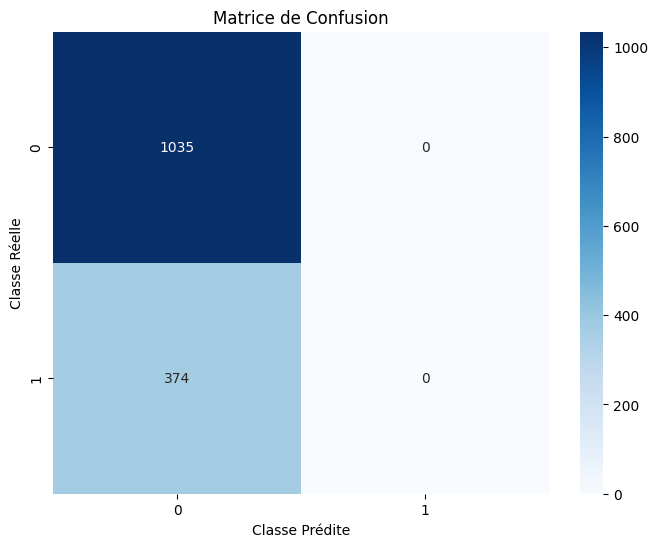

In [12]:

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.show()

# Visualization of the training curves

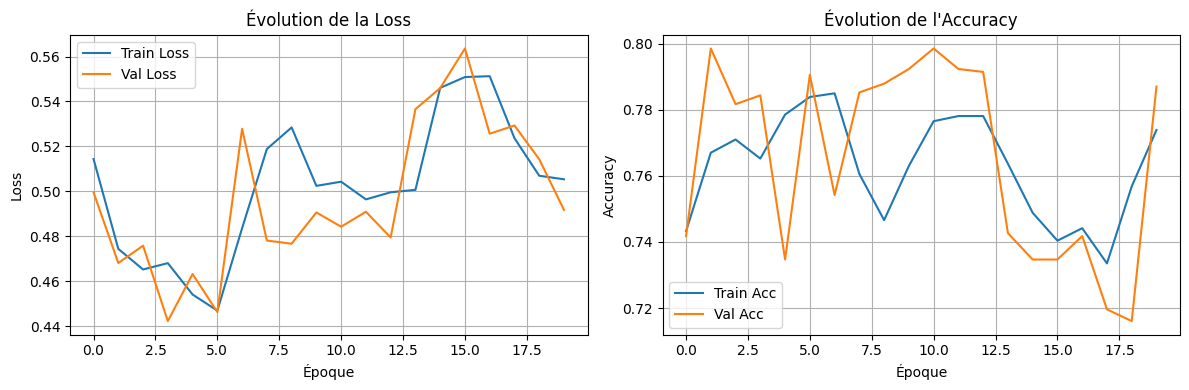

In [13]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)